<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data preparation</a></span></li><li><span><a href="#Data-analysis" data-toc-modified-id="Data-analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data analysis</a></span></li><li><span><a href="#Models-tratining" data-toc-modified-id="Models-tratining-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Models tratining</a></span></li><li><span><a href="#Model-testing" data-toc-modified-id="Model-testing-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Model testing</a></span></li><li><span><a href="#Overall-conclusion" data-toc-modified-id="Overall-conclusion-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Overall conclusion</a></span></li></ul></div>

# Project description: Taxi orders forecast

Taxi Service has compiled historical data on taxi bookings at airports. To involve more drivers at peak times, you need to predict the number of taxi orders for the next hour. Let's build a model for such prediction.

The value of RMSE metric on the test sample should not exceed 48.

**Instructions for project execution**.

1. Let's load the data and resample it by one hour.
2. Analyse the data.
3. Train different models with different hyperparameters. Will make a test set of 10% of the original data.
4. Test the data on the test set and draw conclusions.

**Data description**.

The number of orders is in the `'num_orders'` column.

In [1]:
# Importing required libraries 

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error

import lightgbm as lgb
from lightgbm import LGBMRegressor

from statsmodels.tsa.seasonal import seasonal_decompose

## Data preparation

In [2]:
# loading and reading data

try:
    df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
    
except FileNotFoundError:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

**Data overview**

In [3]:
display(df.info(), df)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [4]:
# ensuring that our index is ordered (sorted in ascending order of time and date) 

df.index.is_monotonic

True

**Conclusion:**.

1. There are 26,496 rows in the dataset, with no missing values.
2. Initial examination of the dataset data shows no problems.
3. The column `datetime` when reading the file was immediately defined as an index and converted to the format `datetime`.
4. Checking the index for ordering confirmed that our index is sorted by increasing time and dates - the dataset presents a sample for the period from March 01 to August 31, 2018 inclusive, with the number of taxi orders for every 10 minutes.

**Will analyse the descriptive statistics of the dataset**

In [5]:
df.describe(percentiles=[.25, .5, .75, .99]).T

,count,mean,std,min,25%,50%,75%,99%,max
num_orders,26496.0,14.070463,9.21133,0.0,8.0,13.0,19.0,43.0,119.0


The average value of taxi orders and the median value are almost identical. 99% of the values do not exceed 43 orders. The maximum value is 119. There is probably a small number of outliers. Will visualise the boxplot.

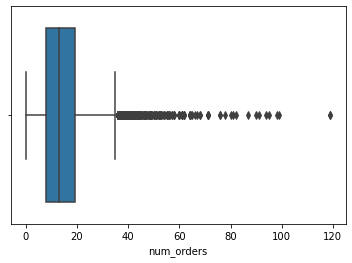

In [6]:
sns.boxplot(df.num_orders);

A certain number of outliers are observed. Let's check the total number of observations over 43 calls, in which 99% of all observations were fit.

In [7]:
print('Общее количество наблюдений, превышающих 43 вызова такси:', len(df.query('num_orders > 43')))
print('Доля от общего кол-во наблюдений в датасете:', round(len(df.query('num_orders > 43'))/len(df), 3))

Общее количество наблюдений, превышающих 43 вызова такси: 238
Доля от общего кол-во наблюдений в датасете: 0.009


Only 238 out of 26496 observations (less than 1 per cent). But since we are not dealing with an ordinary dataset, but with a time series, removing the outliers will lead to gaps in the data. Therefore, we do not remove the outliers and leave the dataset in its original form.

**Resampling by one hour**

Since we need to predict the number of taxi orders for the next hour, we resample our data at one hour intervals instead of 10 minutes as in the original dataset.

In [8]:
df = df.resample('1H').sum()

## Data analysis

In [9]:
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


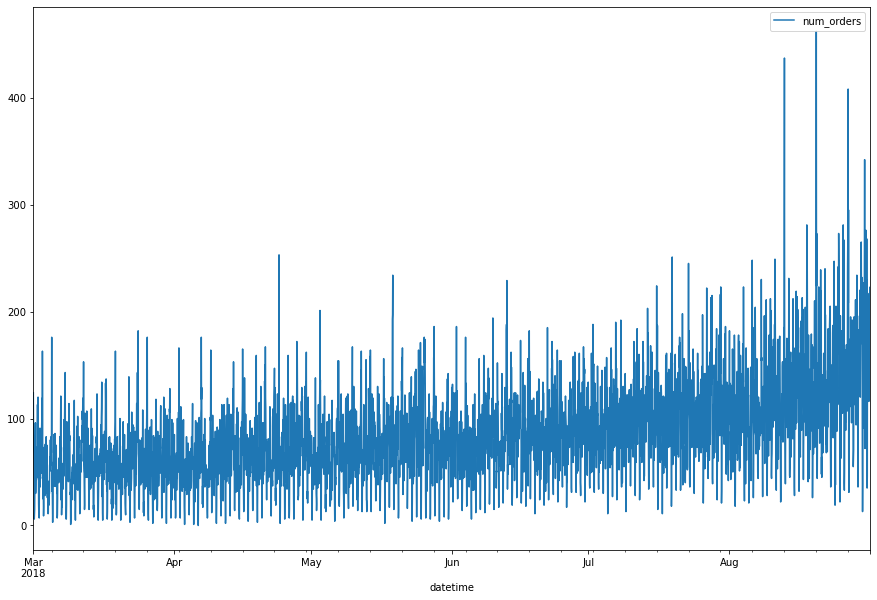

In [10]:
df.plot(figsize=(15,10));

An uptrend can be seen. Let's take a look at the data under a more enlarged grouping - 1 day. Let's also plot the rolling mean and the rolling standard deviation on the graph.

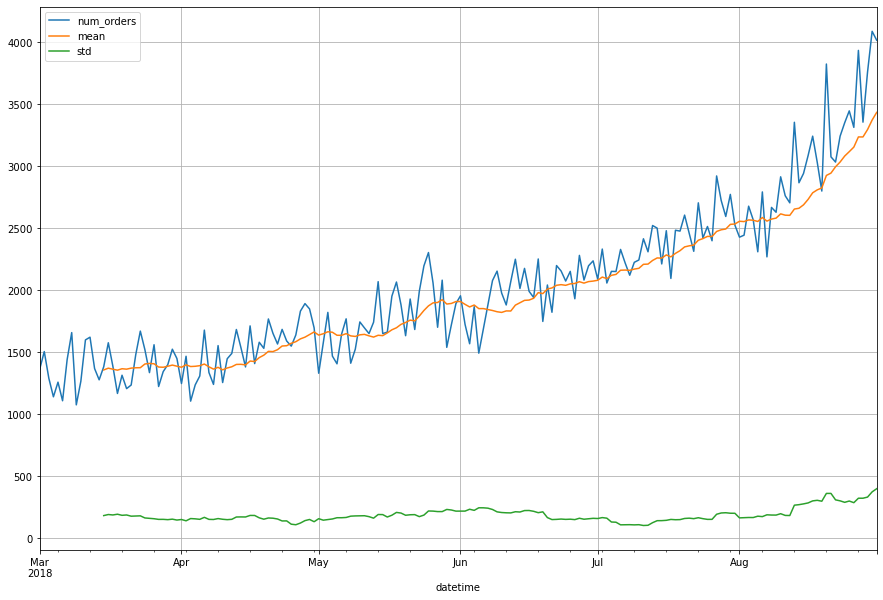

In [11]:
df_daily = df.resample('1D').sum()
df_daily['mean'] = df_daily.rolling(15).mean()
df_daily['std'] = df_daily.num_orders.rolling(15).std()
df_daily.plot(figsize=(15,10), grid=True);

When the data are grouped on the one day, the trend is already clearly visible. In addition, the mean and standard deviation of the series change over time, meaning that the time series are non-stationary and more difficult to predict.

**Trend and Seasonality**

Let's analyse the trend and seasonality of our time series.

Text(0, 0.5, 'Количество заказов')

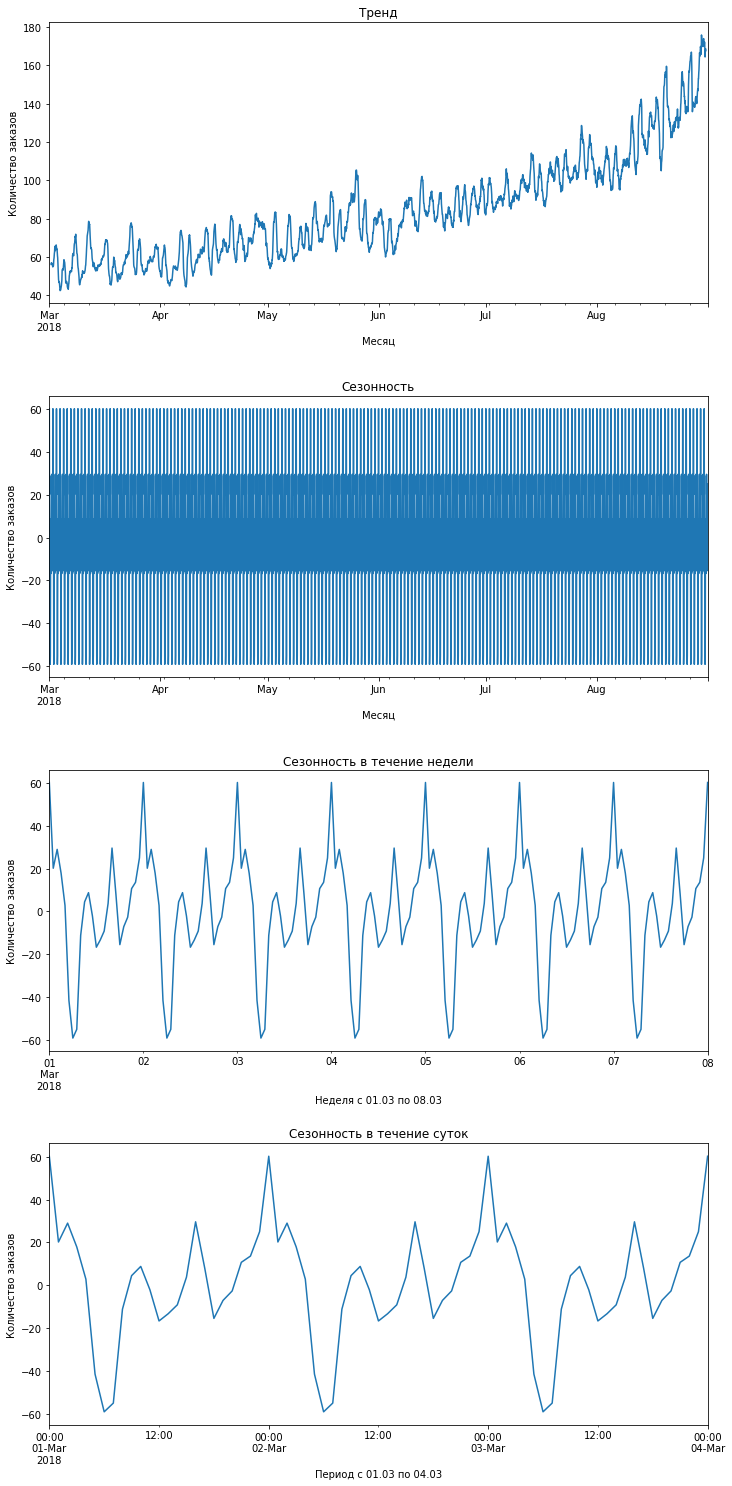

In [12]:
decomposed = seasonal_decompose(df)

# defining the figsize for all graphs

plt.figure(figsize=(10,20));

# subplot with 4 rows and 1 column, plot 1

plt.subplot(411)
decomposed.trend.plot(ax=plt.gca()) 
plt.title('Тренд')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')

plt.tight_layout(h_pad=5)

# plot 2
plt.subplot(412)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')

# plot 3 (seasonality analysis by week)
plt.subplot(413)
decomposed.seasonal['2018-03-01 00:00:00': '2018-03-08 00:00:00'].plot(ax=plt.gca())
plt.title('Сезонность в течение недели')
plt.xlabel('Неделя с 01.03 по 08.03')
plt.ylabel('Количество заказов')

# plot 4 (seasonality analysis by day)
plt.subplot(414)
decomposed.seasonal['2018-03-01 00:00:00': '2018-03-04 00:00:00'].plot(ax=plt.gca())
plt.title('Сезонность в течение суток')
plt.xlabel('Период с 01.03 по 04.03')
plt.ylabel('Количество заказов')

The trend graph clearly shows an uptrend over the whole semiannual period. 

The graph of overall seasonality is difficult to visually assess and draw definite conclusions, so in the third graph we have plotted the seasonality for the first week of March. This graph clearly shows the daily seasonality of the time series. The distribution of taxi orders during the day follows a common pattern. Thus, we can predict the future number of orders by hours, using data from previous seasons. 

Also for a better visualisation of the distribution of orders over the course of a day, the fourth graph shows the distribution of orders over the first three days of March.

Analysis of the seasonality graphs allows us to conclude that our time series exhibits daily seasonality, meaning that every 24 hours the distribution of orders fits into a certain pattern: orders peak at midnight, then in the morning a sharp decline in orders, and then a consistent increase in orders throughout the day (with certain local peaks) before peaking again at midnight.

Given that our dataset reflects taxi bookings from airports, we daresay that this seasonality may be due to the aircraft arrival schedule, which also has timed peaks in arrivals throughout the day. 

## Models tratining

**Features engineering**

Will define a function by which will create the following features:
1. Calendar features: day of the week, hour
2. "Lagging features", which will tell us whether the value of our time series will increase or decrease
3. The rolling mean is a feature that tells us if the overall trend of the time series is increasing or decreasing.

In [13]:
# defining the function for features engineering

def make_features(data, max_lag, rolling_mean_size):
    
    '''
    the function takes in as agruments the dataset, the number of lagging features and the window size for
    creating rolling mean feature. While creating lagging features and rolling mean feautre, the missing values
    are obtained in the first rows of dataset. The function removes these missing values and returns new
    dataset with newly created features.
    '''
        
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    data = data.dropna()
    
    return data

Since in the previous stages of the study we determined that the seasonality of the time series is 24-hour period and our data is grouped by one hour, respectively we apply a function with lagged values and a rolling mean of 24 to set the overall trend of the time series.

In [14]:
df = make_features(df, 24, 24)

In [15]:
df.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,4,0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,56.833333
2018-03-02 01:00:00,120,4,1,90.0,58.0,113.0,66.0,61.0,45.0,73.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,55.416667
2018-03-02 02:00:00,75,4,2,120.0,90.0,58.0,113.0,66.0,61.0,45.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,56.875000
2018-03-02 03:00:00,64,4,3,75.0,120.0,90.0,58.0,113.0,66.0,61.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,57.041667
2018-03-02 04:00:00,20,4,4,64.0,75.0,120.0,90.0,58.0,113.0,66.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,56.958333


As a result of the lagging and rolling mean features creation, missing values were created in the first 24 rows, which were removed by the function call in order to further work on the training of the models.

In [17]:
display(df.isna().sum().sum(), df.shape)

0

(4392, 28)

**Conclusion:**

1. Calendar features, 24 lagging features and a rolling mean feature with a prediction window of 24 hours were created.
2. As a result of creating the attributes, there were missing values in the first 24 rows, which have been removed.
3. After deleting the rows with missing values, a dataset of 4392 rows and 28 columns was obtained.

**Model initializing**

Will train different models with different hyperparameters. 

Will create a list to find the best hyperparameters for the models, and then will initialise the different models.

In [18]:
# creating list to select best models hyperparameters

models = []

Initializing models `LinearRegression`, `RandomForestRegressor` and `LightGBM Regressor`.

In [19]:
# Linear Regression

lr = LinearRegression(n_jobs=-1)

param_grid = {'fit_intercept':[True, False], 'normalize':[True, False], 'copy_X':[True, False]}

models.append(('Linear Regression', lr, param_grid))

In [20]:
# Random Forest Regressor

rfr = RandomForestRegressor(random_state=12345, n_estimators=30, max_features='auto', n_jobs=-1)

param_grid = {'max_depth': np.arange(10, 21, 2), 'min_samples_split': np.arange(2, 11, 2)}

models.append(('Random Forest Regressor', rfr, param_grid))

In [21]:
# LightGBM Regressor

lg = lgb.LGBMRegressor(random_state=12345)

param_grid = {'num_leaves' : [200, 300], 
            'n_estimators' : [100, 150], 
            'learning_rate' : [0.01, 0.05, 0.1]}

models.append(('LightGBM Regressor', lg, param_grid))

**Splitting original dataset into train and test sets**

We will split our original dataset into training and test samples at a ratio of 90:10. We'll define features and target.

In [22]:
# defining features and target 

X = df.drop('num_orders', axis=1)
y = df.num_orders

# splitting dataset into train and test samples at a ratio of 9:1

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)

In [23]:
print(f'Размер исходной выборки: {X.shape[0]} объектов, {X.shape[1]} признаков')
print(f'Размер обучающей выборки: {X_train.shape[0]} объектов, {X_train.shape[1]} признаков')
print(f'Размер тестовой выборки: {X_test.shape[0]} объектов, {X_test.shape[1]} признаков')

Размер исходной выборки: 4392 объектов, 27 признаков
Размер обучающей выборки: 3952 объектов, 27 признаков
Размер тестовой выборки: 440 объектов, 27 признаков


Will define a function that will enumerate the hyperparameters of the models on the hyperparameter grid and return the best of them.

In [24]:
# Function to enumerate the model hyperparameters on the grid

def grid_search(model, param_grid, cv, x, y):
    
    ''' 
    the function takes as arguments the model and parameters grid from created list as well as the number of 
    folds for cross validation and features/target samples.
    '''
    
    tscv = TimeSeriesSplit(n_splits=5)
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=tscv, verbose=1, n_jobs=-1)
    grid_model.fit(x, y)
    best_estimator = grid_model.best_estimator_
    
    return best_estimator

Will define a function that will consolidate into a table the best metrics **RMSE** for each of the models in the training sample.

In [25]:
def table_builder(models):
    
    table = []
    
    for model in models:
        grid = grid_search(model[1], model[2], 3, X_train, y_train)
        predictions = grid.predict(X_train)
        rmse = mean_squared_error(y_train, predictions)**0.5
        
        table.append((model[0], rmse, grid))
        
        print(grid)
        
    final_table = pd.DataFrame(table, columns=['Model', 'RMSE', 'Grid'])
        
    return final_table

In [26]:
final_table = table_builder(models)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
LinearRegression(fit_intercept=False, n_jobs=-1, normalize=True)
Fitting 5 folds for each of 30 candidates, totalling 150 fits
RandomForestRegressor(max_depth=16, max_features='auto', n_estimators=30,
                      n_jobs=-1, random_state=12345)
Fitting 5 folds for each of 12 candidates, totalling 60 fits
LGBMRegressor(learning_rate=0.05, num_leaves=200, random_state=12345)


In [27]:
final_table.sort_values(by='RMSE')

,Model,RMSE,Grid
2,LightGBM Regressor,8.444727,"LGBMRegressor(learning_rate=0.05, num_leaves=2..."
1,Random Forest Regressor,9.614494,"(DecisionTreeRegressor(max_depth=16, max_featu..."
0,Linear Regression,25.845248,"LinearRegression(fit_intercept=False, n_jobs=-..."


## Model testing

The LightGBM Regressor model showed the best (lowest) value of RMSE metric on the training sample. Let us test this model on a test sample, with the best hyperparameters identified during model training.

In [28]:
lg_test = lgb.LGBMRegressor(learning_rate=0.05, num_leaves=200, n_estimators=150, random_state=12345)

lg_test.fit(X_train, y_train)
predictions_test = lg_test.predict(X_test)

print('RMSE на тестовой выборке:', mean_squared_error(y_test, predictions_test)**0.5)

RMSE на тестовой выборке: 42.02944703043546


To reflect the performance of our model, we visualise on a graph the actual orders and the orders predicted by our model over several days. 

<AxesSubplot:xlabel='datetime'>

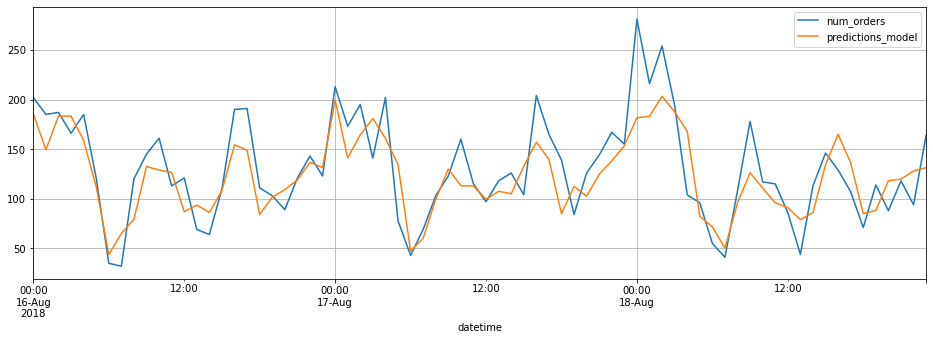

In [29]:
predictions_model = pd.Series(data = predictions_test, name = 'predictions_model', index = X_test.index)

y_test['2018-08-16':'2018-08-18'].plot(figsize=(16,5), grid=True, legend=True)
predictions_model['2018-08-16':'2018-08-18'].plot(grid=True, legend=True)

We can see that the model captured the daily seasonality quite correctly and more or less correctly predicted the values of the target feature on the test sample. 

**Conclusion:**. 

The LightGBM Regressor model showed the best RMSE metric value on the training sample: 8.44. 
The results of the other models on the training sample are Random Forest Regressor at 9.61 and Linear Regression at 25.85.

The best model with the best hyperparameters was tested on the test sample. The RMSE result was 42.03.


## Overall conclusion

There are 26,496 rows in the dataset, with no missing values. Initial examination of the dataset data showed no problems.
The `datetime` column was directly defined as an index and converted to `datetime` format when reading the file.

The dataset presents a sample for the period from March 01 to August 31, 2018 inclusive, with the number of taxi orders for every 10 minutes. Since we need to predict the number of taxi orders for the next hour, we resampled our data at one hour intervals instead of 10 minutes as in the original dataset.

The plotted trend graph clearly shows an uptrend over the entire semiannual period.

The plotted seasonality graph clearly demonstrates the daily seasonality of the time series. The distribution of taxi orders during the 24-hour period follows a common pattern: peak orders occur at midnight, then by morning a sharp decline in orders and again a successive increase in orders during the day (with certain local peaks) to a new peak at midnight. In this way we are able to predict the future number of orders by hours, using data from previous seasons.

During model training, we investigated three models - LightGBM Regressor, Random Forest Regressor and Linear Regression. The LightGBM Regressor model showed the best RMSE metric value on the training sample: 8.44. 
The results of other models on the training set were: Random Forest Regressor - 9.61 and Linear Regression - 25.85.

The best model with the best hyperparameters was tested on the test sample. The RMSE result was found to be 42.03.

To confirm the work of the model we plotted a graph that visualizes the real and predicted by the model taxi orders on the test sample. The model is quite correct in capturing the daily seasonality and more or less correctly predicts the values of the target feature on the test sample.